# 1. Bussiness Problem

# 1.1 Description du problème


Le diagnostic erroné des nombreuses maladies a un impact sur les cultures agricoles et peut entraîner une mauvaise utilisation des produits chimiques, conduisant à l'émergence de souches de pathogènes résistantes, à une augmentation des coûts de production et à davantage d'épidémies, avec des pertes économiques et des impacts environnementaux significatifs. Le diagnostic des maladies basé sur l'observation humaine est long et coûteux, donc un modèle basé sur la vision par ordinateur peut aider à classer efficacement ces maladies.

# 1.2 Énoncé du problème
L'ensemble de données provient de la compétition Kaggle "Plant Pathology 2020 - FGVC7". Dans cette compétition, le défi est de distinguer les feuilles saines, les feuilles infectées par la rouille de la pomme, les feuilles atteintes de la tavelure de la pomme et les feuilles atteintes de plusieurs maladies.

Ensemble de données : https://www.kaggle.com/competitions/plant-pathology-2020-fgvc7

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohamedboutaghratine","key":"a80d0dd82ba357b33a61a84b9af4551b"}'}

In [2]:
#second section
#before importing the dataset we want to use this code
#The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#This permissions change avoids a warning on Kaggle tool startup.

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c plant-pathology-2020-fgvc7

 98% 760M/779M [00:08<00:00, 178MB/s]
100% 779M/779M [00:09<00:00, 90.5MB/s]


In [4]:
#fourth section

from zipfile import ZipFile
file_name = "plant-pathology-2020-fgvc7.zip"
with ZipFile(file_name, 'r') as zip:
    zip.extractall()
print("Done")

Done


# 2. Importer tous les fichiers et bibliothèques nécessaires



In [5]:
!pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00


In [6]:
# importing important libraries
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import keras
import cv2 as cv
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB4
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Input, MaxPool2D, Flatten, Dropout
from keras.layers import Input, GlobalAveragePooling2D, Dense,Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback

In [7]:
data=pd.read_csv("/content/sample_submission.csv")

In [8]:
data.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   image_id           1821 non-null   object 
 1   healthy            1821 non-null   float64
 2   multiple_diseases  1821 non-null   float64
 3   rust               1821 non-null   float64
 4   scab               1821 non-null   float64
dtypes: float64(4), object(1)
memory usage: 71.3+ KB


In [36]:
#Missing values

data.isnull()

,image_id,healthy,multiple_diseases,rust,scab
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
1816,False,False,False,False,False
1817,False,False,False,False,False
1818,False,False,False,False,False
1819,False,False,False,False,False


In [9]:
# loading train and test dataset
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("la dimension de train dataframe est :", train.shape)
print("la dimension de test dataframe est :", test.shape)

la dimension de train dataframe est : (1821, 5)
la dimension de test dataframe est : (1821, 1)


In [9]:
# checking train dataframe
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [39]:
train.isnull()

,image_id,healthy,multiple_diseases,rust,scab
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
1816,False,False,False,False,False
1817,False,False,False,False,False
1818,False,False,False,False,False
1819,False,False,False,False,False


In [10]:
# ajout path de l'image dans train dataframe
train_id = train['image_id'].values
train_image_path = []
for i in train_id:
    train_image_path.append("images/" + i + ".jpg")
train['image_path'] = train_image_path
train.head()

,image_id,healthy,multiple_diseases,rust,scab,image_path
0,Train_0,0,0,0,1,images/Train_0.jpg
1,Train_1,0,1,0,0,images/Train_1.jpg
2,Train_2,1,0,0,0,images/Train_2.jpg
3,Train_3,0,0,1,0,images/Train_3.jpg
4,Train_4,1,0,0,0,images/Train_4.jpg


In [11]:
# ajout path de l'image dans test dataframe
test_id = test['image_id'].values
test_image_path = []
for i in test_id:
    test_image_path.append("images/" + i + ".jpg")
test['image_path'] = test_image_path
test.head()

,image_id,image_path
0,Test_0,images/Test_0.jpg
1,Test_1,images/Test_1.jpg
2,Test_2,images/Test_2.jpg
3,Test_3,images/Test_3.jpg
4,Test_4,images/Test_4.jpg


Text(0, 0.5, "Nombre d'images")

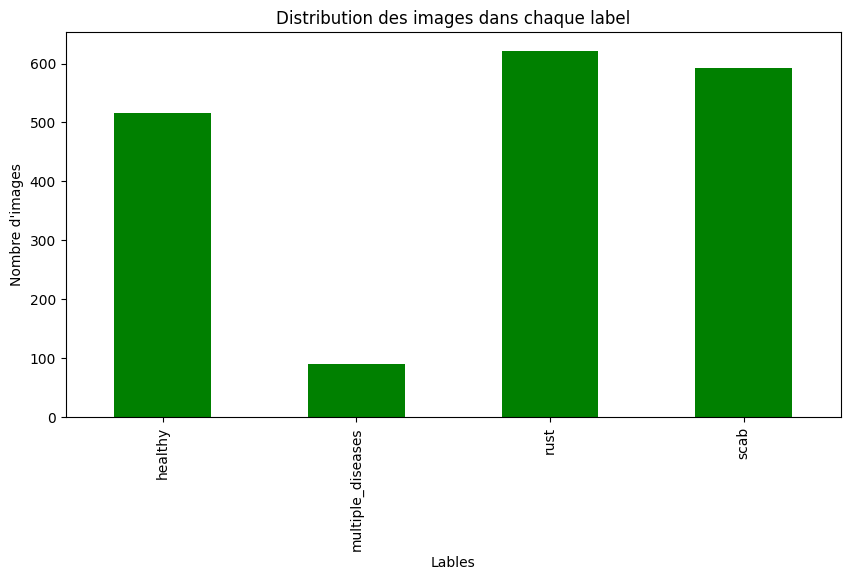

In [12]:
# Tracer la distribution des images dans chaque étiquette de train dataframe
train[['healthy','multiple_diseases','rust','scab',]].sum().plot.bar(figsize = (10,5), title = "Distribution des images dans chaque label",color="green")
plt.xlabel("Lables")
plt.ylabel("Nombre d'images")

## 2.2 Data Splitting

In [14]:
# Devision du train dataset en train et validation  dataset
from sklearn.model_selection import train_test_split
X_train, X_valid = train_test_split(train.drop(['image_id'], axis = 1), test_size=0.20, random_state=13, stratify = train[['healthy','multiple_diseases','rust','scab']])
print(X_train.shape)
print(X_valid.shape)

(1456, 5)
(365, 5)


In [15]:
#  train dataframe
X_train.head()

,healthy,multiple_diseases,rust,scab,image_path
976,0,0,1,0,images/Train_976.jpg
777,1,0,0,0,images/Train_777.jpg
1256,0,0,1,0,images/Train_1256.jpg
1568,0,0,0,1,images/Train_1568.jpg
1093,0,0,1,0,images/Train_1093.jpg


In [55]:
# #  train dataframe
X_valid.head()

,healthy,multiple_diseases,rust,scab,image_path
308,0,0,0,1,images/Train_308.jpg
1222,0,0,1,0,images/Train_1222.jpg
1506,0,0,0,1,images/Train_1506.jpg
45,0,0,1,0,images/Train_45.jpg
481,0,0,1,0,images/Train_481.jpg


# 3. Exploratory Data Analysis (EDA)

## 3.1 Distribution of Lables

Text(0, 0.5, "Nombre d'Images")

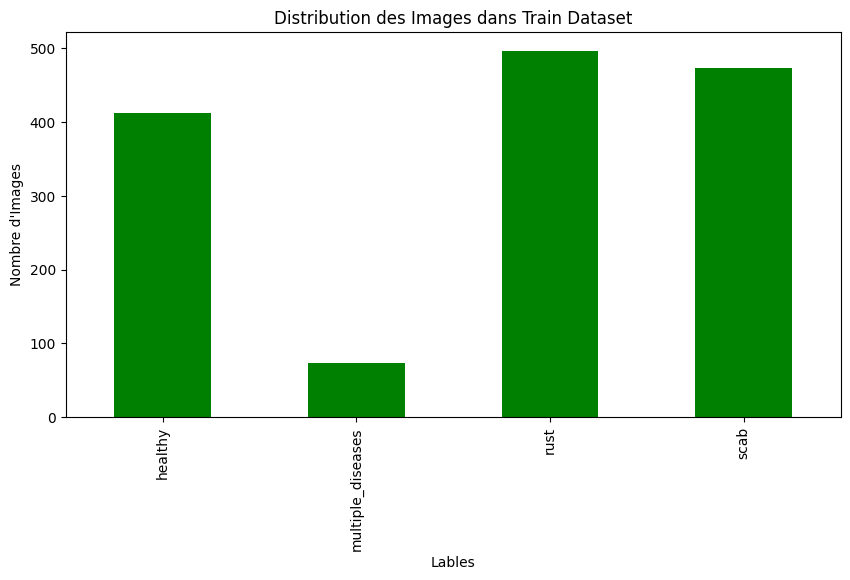

In [16]:
#Tracer la distribution des images dans chaque étiquette de train dataframe
X_train[['healthy','multiple_diseases','rust','scab']].sum().plot.bar(figsize = (10,5), title = "Distribution des Images dans Train Dataset",color="green")
plt.xlabel("Lables")
plt.ylabel("Nombre d'Images")

On peut observer que label 'multiple_diseases' est fortement sous-représentée par rapport aux autres labels.

In [17]:
# le nombre exact d'images dans chaque label dans X_train
X_train[['healthy','multiple_diseases','rust','scab',]].sum()

,0
healthy,413
multiple_diseases,73
rust,497
scab,473


In [18]:
# le nombre exact d'images dans chaque label dans X_valid

X_valid[['healthy','multiple_diseases','rust','scab']].sum()

,0
healthy,103
multiple_diseases,18
rust,125
scab,119


##  3.2 Visualisation des feuilles Healthy


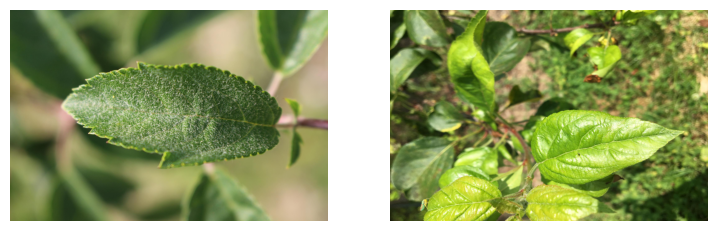

In [59]:
healthy = X_train[X_train['healthy']==1]['image_path'].values[:2]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))  # Ajuster la taille de la figure
for i in range(2):
    ax[i].imshow(cv.cvtColor(cv.imread(healthy[i]), cv.COLOR_BGR2RGB))
    ax[i].axis('off')  # Désactiver les axes
plt.show()


        On peut observer que les feuilles healthy sont toutes vertes et n'ont pas de tâches.


## 3.3 Visualisation de Rust Leaves


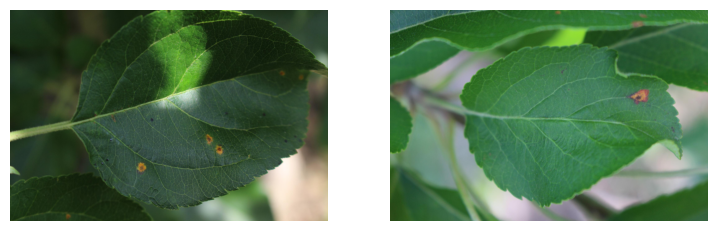

In [58]:
healthy = X_train[X_train['rust']==1]['image_path'].values[:2]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))  # Ajuster la taille de la figure
for i in range(2):
    ax[i].imshow(cv.cvtColor(cv.imread(healthy[i]), cv.COLOR_BGR2RGB))
    ax[i].axis('off')  # Désactiver les axes
plt.show()

       Sur RUST LEAVES , nous pouvons voir des taches jaunes ou bronzées.


## 3.4 Visualisation Scab Leaves

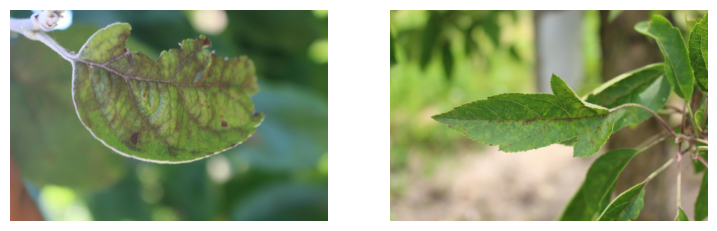

In [61]:
healthy = X_train[X_train['scab']==1]['image_path'].values[:2]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))  # Ajuster la taille de la figure
for i in range(2):
    ax[i].imshow(cv.cvtColor(cv.imread(healthy[i]), cv.COLOR_BGR2RGB))
    ax[i].axis('off')  # Désactiver les axes
plt.show()

   Dans ces scab leaves, nous pouvons voir de grandes taches brunes et certaines feuilles enroulées.

## 3.4 Visualisation Leaves avec Multiple Diseases


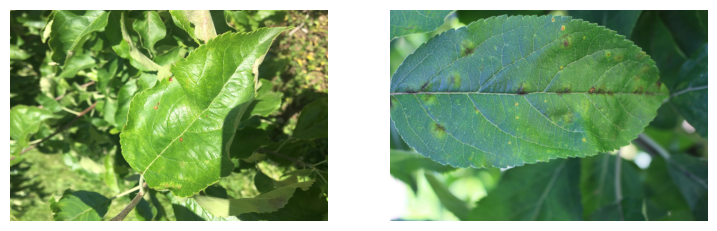

In [63]:
healthy = X_train[X_train['multiple_diseases']==1]['image_path'].values[:2]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))  # Ajuster la taille de la figure
for i in range(2):
    ax[i].imshow(cv.cvtColor(cv.imread(healthy[i]), cv.COLOR_BGR2RGB))
    ax[i].axis('off')  # Désactiver les axes
plt.show()

Sur les feuilles atteintes de plusieurs maladies, on peut observer à la fois des taches jaunes et brunes, des trous dans les feuilles et de nombreuses autres maladies multiples sur les feuilles.

# 4. Preprocessing Image Data

## 4.1 Upsampling Train Dataset

Comme nous pouvons le constater, l'étiquette 'multiple_diseases' est très déséquilibrée par rapport aux trois autres étiquettes. Ainsi, pour obtenir des résultats plus précis, nous allons surréchantillonner le jeu de données d'entraînement. Nous utiliserons la bibliothèque SMOTE pour surréchantillonner notre jeu de données d'entraînement.

In [64]:
# convertir les images d'entraînement en un tableau Numpy 3D.
X_train_arr = []
for img in tqdm(X_train['image_path'].values):
    loaded_img = load_img(img, target_size = (256, 256))
    img_arr = img_to_array(loaded_img)
    X_train_arr.append(img_arr)

X_train_arr = np.array(X_train_arr)
X_train_arr.shape

100%|██████████| 1456/1456 [00:28<00:00, 50.75it/s]


(1456, 256, 256, 3)

In [20]:
# creating y_train dataset
y_train_arr = X_train[['healthy','multiple_diseases','rust','scab']].values
y_train_arr.shape

(1456, 4)

In [21]:
# Utilisation SMOTE library pour équilibrer le training dataset
sm = SMOTE(random_state=13)
X_train_arr_new, y_train_new = sm.fit_resample(X_train_arr.reshape((-1, 256 * 256 * 3)), y_train_arr)
X_train_new = X_train_arr_new.reshape(-1, 256, 256, 3)
X_train_new.shape

(1988, 256, 256, 3)

In [22]:
y_train_new.shape

(1988, 4)

Text(0, 0.5, "Nombre d'Images")

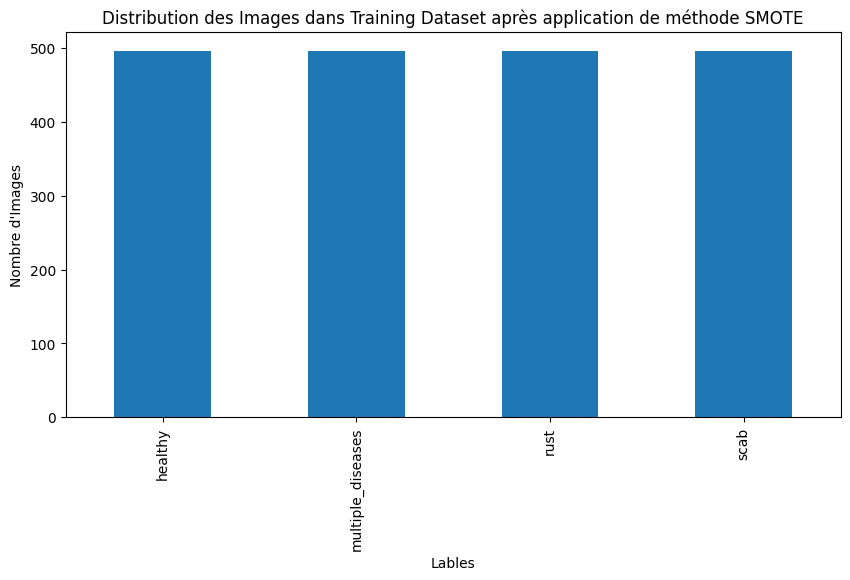

In [22]:
# Revoir la Distribution des Images pour tout labels pour training dataframe après équilibration
new_y_train_df = pd.DataFrame(data = y_train_new, columns = ['healthy','multiple_diseases','rust','scab'])
new_y_train_df.sum().plot.bar(figsize = (10,5), title = "Distribution des Images dans Training Dataset après application de méthode SMOTE")
plt.xlabel("Lables")
plt.ylabel("Nombre d'Images")

## 4.2 Data Augmentation

In [23]:
# creation augmentation des images
train_datagen = ImageDataGenerator(rotation_range = 20, brightness_range = (0.5, 1.5), shear_range = 0.2,
                                   zoom_range =  0.2, horizontal_flip = True, vertical_flip = True, rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255)

In [24]:
# creation train, validation and test image generator
train_generator = train_datagen.flow(X_train_new, y_train_new, batch_size = 32, seed = 15, shuffle = True)

valid_generator = test_datagen.flow_from_dataframe(dataframe = X_valid, x_col = "image_path", y_col = ['healthy', 'multiple_diseases', 'rust', 'scab'],
                                                   batch_size = 32, seed = 15, shuffle = False, class_mode = "raw", target_size = (256, 256))

test_generator = test_datagen.flow_from_dataframe(dataframe = test, x_col = "image_path", y_col = None, batch_size = 1,
                                                  seed = 15, shuffle = False, class_mode = None,target_size = (256, 256))

Found 365 validated image filenames.
Found 1821 validated image filenames.


## 1. Entraînement du Modèle Random Forest

Entrée : Les images sont aplaties, c'est-à-dire converties en vecteurs 1D (de taille (256 * 256 * 3) pour chaque image).

Caractéristiques utilisées : Les caractéristiques sont directement extraites à partir des pixels des images, sans pré-traitement ou extraction d'éléments sémantiques complexes.

In [66]:
# =======================\n# 1. Entraînement du Modèle Random Forest\n# =======================
from sklearn.ensemble import RandomForestClassifier

# Aplatir les images préparées pour Random Forest
X_flat = X_train_new.reshape((X_train_new.shape[0], -1))  # (num_images, 256*256*3)

# Conversion des étiquettes one-hot en labels uniques
y_labels = np.argmax(y_train_new, axis=1)

# Séparation en jeu d'entraînement et de validation
X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(X_flat, y_labels, test_size=0.2, random_state=42)

# Entraînement du Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

RandomForestClassifier(random_state=42)

##Evaluation du modèle

In [67]:
# =======================\n# 2. Évaluation du Modèle\n# =======================
from sklearn.metrics import classification_report

# Prédictions sur le jeu de validation
y_pred = rf_model.predict(X_val_rf)

# Rapport de classification
print(classification_report(y_val_rf, y_pred, target_names=['healthy', 'multiple_diseases', 'rust', 'scab']))


                   precision    recall  f1-score   support

          healthy       0.63      0.59      0.61        97
multiple_diseases       0.95      0.97      0.96       107
             rust       0.52      0.48      0.50       101
             scab       0.53      0.61      0.57        93

         accuracy                           0.67       398
        macro avg       0.66      0.66      0.66       398
     weighted avg       0.67      0.67      0.67       398



#Prédiction avec Random Forest

In [71]:
img = image.load_img('/content/images/Test_3.jpg', target_size=(256, 256))
img_array = image.img_to_array(img).reshape(1, -1)
print(['healthy', 'multiple_diseases', 'rust', 'scab'][rf_model.predict(img_array)[0]])

healthy


# REGRESSION LOGISTIQUE

In [73]:
from sklearn.linear_model import LogisticRegression

# Entraînement de la régression logistique
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X_train_rf, y_train_rf)


LogisticRegression(max_iter=1000, random_state=42)

In [74]:
from sklearn.metrics import classification_report

y_pred_log_reg = log_reg_model.predict(X_val_rf)
print(classification_report(y_val_rf, y_pred_log_reg, target_names=['healthy', 'multiple_diseases', 'rust', 'scab']))



                   precision    recall  f1-score   support

          healthy       0.51      0.51      0.51        97
multiple_diseases       0.86      0.95      0.91       107
             rust       0.41      0.31      0.35       101
             scab       0.40      0.46      0.43        93

         accuracy                           0.57       398
        macro avg       0.55      0.56      0.55       398
     weighted avg       0.55      0.57      0.56       398



# Prédiction avec Regression logistique

In [75]:
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img('/content/images/Test_190.jpg', target_size=(256, 256))
y_pred = log_reg_model.predict(image.img_to_array(img).reshape(1, -1))
print(['healthy', 'multiple_diseases', 'rust', 'scab'][y_pred[0]])


scab


# 5. Deep Learning Models

## 5.1 VGG-19

Utilisation de la technique de transfert d'apprentissage et entraînement du modèle VGG-19 avec les poids pré-entraînés du modèle ImageNet.

In [ ]:
# Input layer
input_layer = Input(shape=(256, 256, 3))

vgg19_model = VGG19(include_top = False, weights = 'imagenet', input_tensor = input_layer)

# mark loaded layers as not trainable
for layer in vgg19_model.layers:
	layer.trainable = False

# 2D Convolution layers
convo_layer = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu',padding = "same", kernel_initializer = tf.keras.initializers.HeNormal(seed = 10))(vgg19_model.output)

# 2D Maxpooling layers
maxpool_layer = MaxPool2D(pool_size = (2,2), strides = (1,1), padding = 'valid')(convo_layer)

# Flatten Layer
flatten_layer = Flatten()(maxpool_layer)

#Dense layer
dense_layer_1 = Dense(512, activation = 'relu')(flatten_layer)

#Dense layer
dense_layer_2 = Dense(256, activation = 'relu')(dense_layer_1)

#Dense layer
dense_layer_3 = Dense(128, activation = 'relu')(dense_layer_2)

# Dense output layer
output = Dense(4, activation = 'softmax')(dense_layer_3)

#Creating a model
model_vgg19 = Model(inputs = input_layer, outputs = output)

In [ ]:
model_vgg19.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
# training vgg19 model
earlystop = EarlyStopping(monitor = 'val_accuracy', patience = 10, verbose = 1)
lr_reduced = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 3, verbose = 1)

checkpoints = ModelCheckpoint(filepath = "best_model_vgg19.hdf5", monitor = 'val_accuracy', save_best_only = True, mode = 'max', verbose = 1)

callback_list = [lr_reduced, earlystop, checkpoints]

model_vgg19.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

# calculating train and test step size
step_size_train = train_generator.n//train_generator.batch_size
step_size_valid = valid_generator.n//valid_generator.batch_size

history_vgg19 = model_vgg19.fit(train_generator, steps_per_epoch = step_size_train, epochs = 50,
                        callbacks = callback_list, validation_data = valid_generator, validation_steps = step_size_valid)

Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 1.3802 - accuracy: 0.3098
Epoch 1: val_accuracy improved from -inf to 0.42045, saving model to best_model_1.hdf5
62/62 [==============================] - 165s 2s/step - loss: 1.3802 - accuracy: 0.3098 - val_loss: 1.3043 - val_accuracy: 0.4205 - lr: 0.0010
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 1.2637 - accuracy: 0.4085
Epoch 2: val_accuracy did not improve from 0.42045
62/62 [==============================] - 57s 914ms/step - loss: 1.2637 - accuracy: 0.4085 - val_loss: 1.2100 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 3/50
62/62 [==============================] - ETA: 0s - loss: 1.1709 - accuracy: 0.4852
Epoch 3: val_accuracy improved from 0.42045 to 0.47727, saving model to best_model_1.hdf5
62/62 [==============================] - 58s 933ms/step - loss: 1.1709 - accuracy: 0.4852 - val_loss: 1.1613 - val_accuracy: 0.4773 - lr: 0.0010
Epoch 4/50
62/62 [==============================] - ETA: 

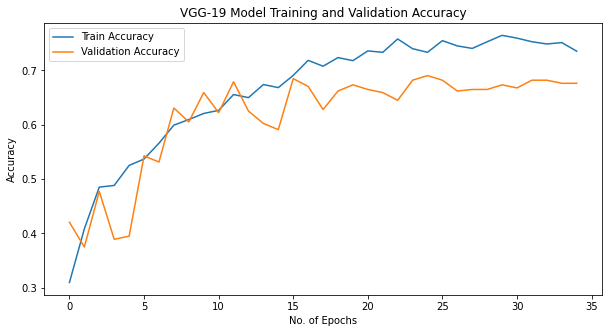

In [ ]:
# plotting VGG-19 Model Accuracy history
fig, ax = plt.subplots(figsize = (10,5))
hist_vgg19 = history_vgg19.history
plt.plot(range(len(hist_vgg19["accuracy"])), hist_vgg19["accuracy"], label = "Train Accuracy")
plt.plot(range(len(hist_vgg19["val_accuracy"])), hist_vgg19["val_accuracy"], label = "Validation Accuracy")
plt.title('VGG-19 Model Training and Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

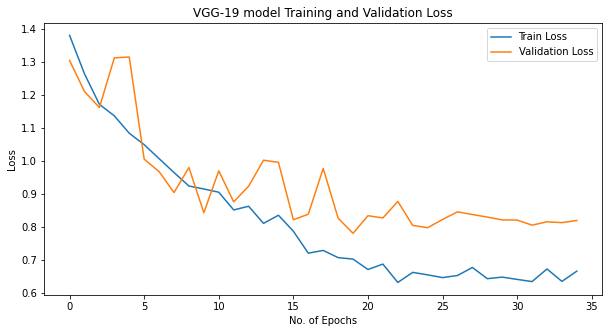

In [ ]:
# plotting VGG-19 Model Loss history
fig, ax = plt.subplots(figsize = (10,5))
hist_vgg19 = history_vgg19.history
plt.plot(range(len(hist_vgg19["loss"])), hist_vgg19["loss"], label = "Train Loss")
plt.plot(range(len(hist_vgg19["val_loss"])), hist_vgg19["val_loss"], label = "Validation Loss")
plt.title('VGG-19 model Training and Validation Loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 5.2 ResNet50

Utilisation de la technique de transfert d'apprentissage et entraînement du modèle ResNet50 avec les poids pré-entraînés du modèle ImageNet.

In [ ]:
# Input layer
input_layer = Input(shape=(256, 256, 3))

resnet50_model = ResNet50(include_top = False, weights = 'imagenet', input_tensor = input_layer)

# Global Pooling Layer
global_pooling_layer = GlobalAveragePooling2D()(resnet50_model.output)

# Dense layer
dense_layer_1 = Dense(256, activation = 'relu')(global_pooling_layer)

# Dense layer
dense_layer_2 = Dense(128, activation = 'relu')(dense_layer_1)

# Dense output layer
output = Dense(4, activation = 'softmax')(dense_layer_2)

#Creating a model
model_resnet50 = Model(inputs = input_layer, outputs = output)

In [ ]:
model_resnet50.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_10[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
# training resnet50 model
earlystop = EarlyStopping(monitor = 'val_accuracy', patience = 15, verbose = 1)
lr_reduced = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 3)

checkpoints = ModelCheckpoint(filepath = "best_model_resnet50.hdf5", monitor = 'val_accuracy', save_best_only = True, mode = 'max')

callback_list = [lr_reduced, earlystop, checkpoints]

model_resnet50.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

# calculating train and test step size
step_size_train = train_generator.n//train_generator.batch_size
step_size_valid = valid_generator.n//valid_generator.batch_size

history_resnet50 = model_resnet50.fit(train_generator, steps_per_epoch = step_size_train, epochs = 50,
            callbacks = callback_list, validation_data = valid_generator, validation_steps = step_size_valid)

Epoch 1/50
62/62 [==============================] - 81s 1s/step - loss: 0.9107 - accuracy: 0.6672 - val_loss: 48.4700 - val_accuracy: 0.3295 - lr: 0.0010
Epoch 2/50
62/62 [==============================] - 67s 1s/step - loss: 0.5854 - accuracy: 0.7802 - val_loss: 13.1500 - val_accuracy: 0.2784 - lr: 0.0010
Epoch 3/50
62/62 [==============================] - 67s 1s/step - loss: 0.5393 - accuracy: 0.7965 - val_loss: 1.5691 - val_accuracy: 0.2784 - lr: 0.0010
Epoch 4/50
62/62 [==============================] - 66s 1s/step - loss: 0.4605 - accuracy: 0.8400 - val_loss: 1.4883 - val_accuracy: 0.2784 - lr: 0.0010
Epoch 5/50
62/62 [==============================] - 70s 1s/step - loss: 0.3159 - accuracy: 0.8829 - val_loss: 1.8039 - val_accuracy: 0.3409 - lr: 4.0000e-04
Epoch 6/50
62/62 [==============================] - 67s 1s/step - loss: 0.2684 - accuracy: 0.9100 - val_loss: 2.1998 - val_accuracy: 0.2784 - lr: 4.0000e-04
Epoch 7/50
62/62 [==============================] - 66s 1s/step - loss: 

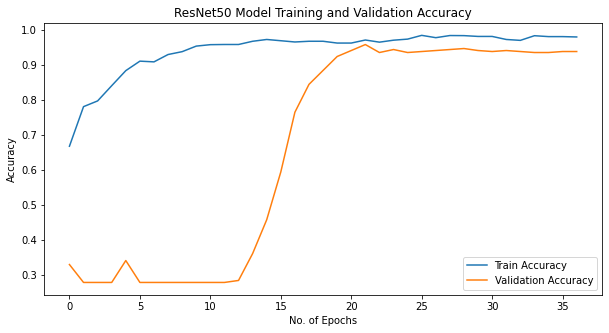

In [ ]:
# plotting ResNet50 Model Accuracy history
fig, ax = plt.subplots(figsize = (10,5))
hist_resnet50 = history_resnet50.history
plt.plot(range(len(hist_resnet50["accuracy"])), hist_resnet50["accuracy"], label = "Train Accuracy")
plt.plot(range(len(hist_resnet50["val_accuracy"])), hist_resnet50["val_accuracy"], label = "Validation Accuracy")
plt.title('ResNet50 Model Training and Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

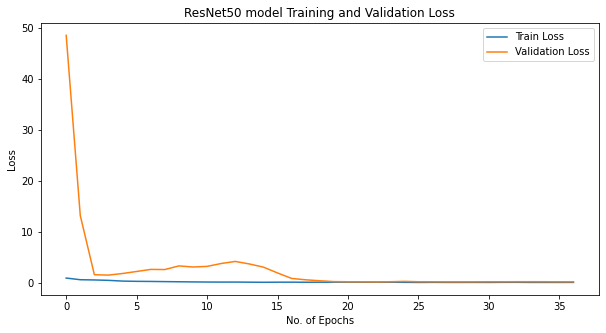

In [ ]:
# plotting ResNet50 Model Loss history
fig, ax = plt.subplots(figsize = (10,5))
hist_resnet50 = history_resnet50.history
plt.plot(range(len(hist_resnet50["loss"])), hist_resnet50["loss"], label = "Train Loss")
plt.plot(range(len(hist_resnet50["val_loss"])), hist_resnet50["val_loss"], label = "Validation Loss")
plt.title('ResNet50 model Training and Validation Loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 5.3 EfficientNet B4

Utilisation de la technique de transfert d'apprentissage et entraînement du modèle EfficientNet B4 avec les poids pré-entraînés du modèle ImageNet.  

In [25]:
# Input layer
input_layer = Input(shape=(256, 256, 3))

efficientnet_model = EfficientNetB4(include_top = False, weights = 'imagenet', input_tensor = input_layer)

# Global Pooling Layer
global_pooling_layer = GlobalAveragePooling2D()(efficientnet_model.output)

# Dense layer
dense_layer_1 = Dense(512, activation = 'relu')(global_pooling_layer)

# Dense layer
dense_layer_2 = Dense(256, activation = 'relu')(dense_layer_1)

# Dense layer
dense_layer_3 = Dense(128, activation = 'relu')(dense_layer_2)

# Dense output layer
output = Dense(4, activation = 'softmax')(dense_layer_3)

#Creating a model
model_efficientnetb4 = Model(inputs = input_layer, outputs = output)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#1.Définition du mdoèle des **embeddings**


In [27]:
from tensorflow.keras.models import Model

# Créer un modèle pour l'extraction des embeddings
embedding_model = Model(inputs=model_efficientnetb4.input, outputs=model_efficientnetb4.layers[2].output)


##2. Extraire les embeddings des images d'entraînement


In [77]:
# Créer un modèle pour extraire les embeddings à partir de la couche de GlobalAveragePooling2D
embedding_model = Model(inputs=model_efficientnetb4.input,
                        outputs=model_efficientnetb4.layers[-5].output)


In [78]:
# Extraire les embeddings pour le dataset d'entraînement
X_embeddings = embedding_model.predict(X_train_new, batch_size=32, verbose=1)

print(f"Shape des embeddings : {X_embeddings.shape}")  # (nombre d'images, 1792)


63/63 ━━━━━━━━━━━━━━━━━━━━ 504s 8s/step
Shape des embeddings : (1988, 1792)


# Affichage embeedings

In [79]:
# Convertir les embeddings en DataFrame pour une meilleure visualisation
embeddings_df = pd.DataFrame(X_embeddings)

# Afficher les 5 premières lignes des embeddings
print(embeddings_df.head())


       0         1         2         3         4         5         6     \
0  0.646709 -0.196166 -0.164617 -0.104676 -0.263238 -0.191788 -0.236903   
1 -0.105694 -0.104346 -0.198757 -0.177046 -0.233935 -0.150590 -0.143583   
2  0.471976 -0.175240 -0.147086 -0.127213 -0.050582 -0.150886 -0.219763   
3  0.256385 -0.199438 -0.189042 -0.198255 -0.246593 -0.165044 -0.251774   
4  0.072516 -0.165677 -0.132544 -0.117967 -0.234913 -0.209914 -0.173342   

       7         8         9     ...      1782      1783      1784      1785  \
0  0.202967 -0.146998  0.175541  ... -0.195272 -0.150589 -0.160838  1.125667   
1 -0.034539 -0.189459  0.132224  ... -0.215980 -0.194212 -0.009573  0.757630   
2  0.135811 -0.125210  0.284537  ... -0.242319 -0.172840 -0.205737  1.339729   
3  0.280745 -0.135790 -0.061099  ... -0.215833 -0.209436 -0.187260  0.710882   
4 -0.052351 -0.097393  0.205701  ... -0.238297 -0.157439 -0.103061  1.336230   

       1786      1787      1788      1789      1790      1791  
0  0

## 3. Préparer les étiquettes


In [80]:
from sklearn.preprocessing import LabelEncoder

# Convertir les étiquettes one-hot en labels numériques
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(np.argmax(y_train_new, axis=1))


## 4. Entraîner un modèle Random Forest avec les embeddings


In [81]:
# Diviser les données en train/validation
X_train_emb, X_val_emb, y_train_emb, y_val_emb = train_test_split(X_embeddings, y_labels, test_size=0.2, random_state=42)

# Entraîner le modèle Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_emb, y_train_emb)

# Prédictions et évaluation
y_pred = rf_model.predict(X_val_emb)
print(f"Accuracy: {accuracy_score(y_val_emb, y_pred)}")

# Convertir les noms de classes en chaînes si nécessaire
target_names = [str(cls) for cls in label_encoder.classes_]
print(classification_report(y_val_emb, y_pred, target_names=target_names))


Accuracy: 0.8768844221105527
              precision    recall  f1-score   support

           0       0.79      0.89      0.83        97
           1       0.95      0.92      0.93       107
           2       0.92      0.87      0.89       101
           3       0.86      0.83      0.84        93

    accuracy                           0.88       398
   macro avg       0.88      0.88      0.88       398
weighted avg       0.88      0.88      0.88       398



#Random forest (avec embeddings) validation/training accuracy

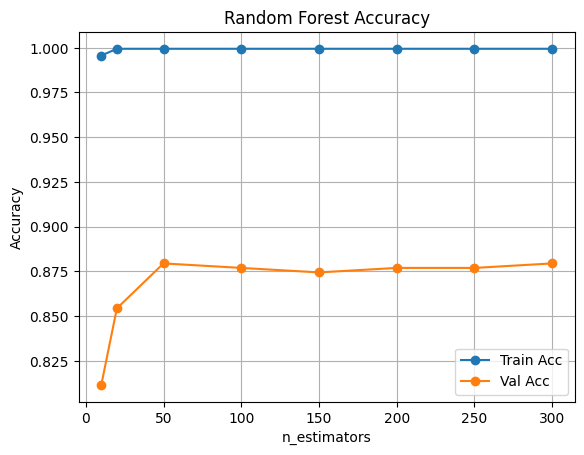

(<matplotlib.legend.Legend at 0x7cc3c900cb90>, None, None)

In [45]:
X_tr, X_val, y_tr, y_val = train_test_split(X_embeddings, y_labels, test_size=0.2, random_state=42)
n_estimators_list = [10, 20, 50, 100, 150, 200, 250, 300]

train_acc, val_acc = [], []
for n in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n, random_state=42).fit(X_tr, y_tr)
    train_acc.append(accuracy_score(y_tr, rf.predict(X_tr)))
    val_acc.append(accuracy_score(y_val, rf.predict(X_val)))

plt.plot(n_estimators_list, train_acc, label='Train Acc', marker='o')
plt.plot(n_estimators_list, val_acc, label='Val Acc', marker='o')
plt.title('Random Forest Accuracy'), plt.xlabel('n_estimators'), plt.ylabel('Accuracy')
plt.legend(), plt.grid(True), plt.show()


In [46]:
# model summary
model_efficientnetb4.summary

<bound method Model.summary of <Functional name=functional, built=True>>

# EfficientNet B4 Model Training

In [47]:
from keras.callbacks import ModelCheckpoint
# training efficientnetb4 model
lr_reduced = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 3)

checkpoints = ModelCheckpoint(filepath = "best_model_efficientnetb4.keras", monitor = 'val_accuracy',
                              save_best_only = True, mode = 'max')

callback_list = [lr_reduced, checkpoints]

model_efficientnetb4.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                             loss = 'categorical_crossentropy', metrics = ['accuracy'])

# calculating train and test step size
step_size_train = train_generator.n//train_generator.batch_size
step_size_valid = valid_generator.n//valid_generator.batch_size

history_efficientnetb4 = model_efficientnetb4.fit(train_generator,
                                                  steps_per_epoch = step_size_train,
                                                  epochs = 50,
                                                  callbacks = callback_list,
                                                  validation_data = valid_generator,
                                                  validation_steps = step_size_valid)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.6510 - loss: 0.8777 - val_accuracy: 0.2784 - val_loss: 1.4022 - learning_rate: 0.0010
Epoch 2/50
 1/62 ━━━━━━━━━━━━━━━━━━━━ 28s 461ms/step - accuracy: 0.8750 - loss: 0.3311

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.8750 - loss: 0.3311 - val_accuracy: 0.2784 - val_loss: 1.4362 - learning_rate: 0.0010
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 73s 801ms/step - accuracy: 0.8658 - loss: 0.3969 - val_accuracy: 0.2784 - val_loss: 2.9810 - learning_rate: 0.0010
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.8750 - loss: 0.3437 - val_accuracy: 0.2784 - val_loss: 2.4814 - learning_rate: 0.0010
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 83s 901ms/step - accuracy: 0.9247 - loss: 0.2303 - val_accuracy: 0.2784 - val_loss: 2.4100 - learning_rate: 4.0000e-04
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 1.0000 - loss: 0.0600 - val_accuracy: 0.2784 - val_loss: 2.3865 - learning_rate: 4.0000e-04
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9523 - loss: 0.1664 - val_accuracy: 0.2812 - val_loss: 2.8729 - learning_rate: 4.0000e-04
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 1.0000 - loss: 0.0457 - va

#EfficientNetB4 validation/training accuracy

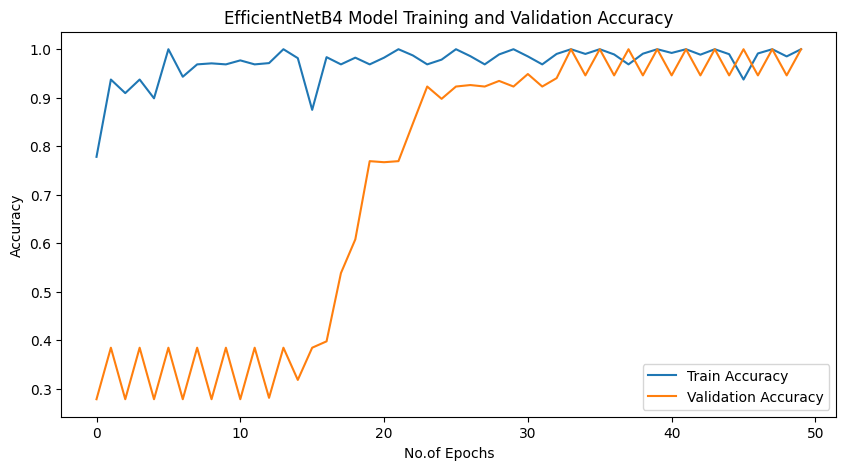

In [ ]:
# plotting EfficientNet B4 Model Accuracy history
fig, ax = plt.subplots(figsize = (10,5))
hist_efficientnetb4 = history_efficientnetb4.history
plt.plot(range(len(hist_efficientnetb4["accuracy"])), hist_efficientnetb4["accuracy"],
         label = "Train Accuracy")
plt.plot(range(len(hist_efficientnetb4["val_accuracy"])), hist_efficientnetb4["val_accuracy"],
         label = "Validation Accuracy")
plt.title('EfficientNetB4 Model Training and Validation Accuracy')
plt.xlabel('No.of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

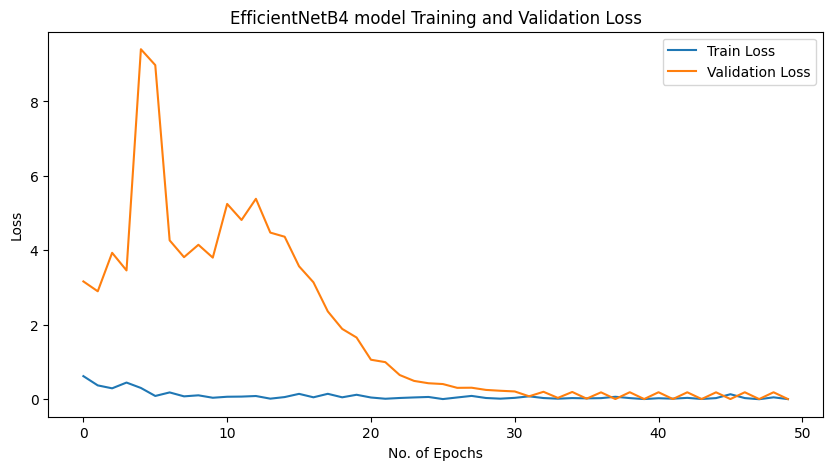

In [ ]:
# plotting EfficientNet B4 Model Loss history
fig, ax = plt.subplots(figsize = (10,5))
hist_efficientnetb4 = history_efficientnetb4.history
plt.plot(range(len(hist_efficientnetb4["loss"])), hist_efficientnetb4["loss"],
         label = "Train Loss")
plt.plot(range(len(hist_efficientnetb4["val_loss"])), hist_efficientnetb4["val_loss"],
         label = "Validation Loss")
plt.title('EfficientNetB4 model Training and Validation Loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# COMPARAISON AVEC LES MODELES

In [ ]:
#Création et configuration de la table
from prettytable import PrettyTable

myTable= PrettyTable(["Deep Learning Models", "Train Accuracy", "Validation Accuracy"])
# adding rows
myTable.add_row(["VGG-19", "0.7331", "0.6903"])
myTable.add_row(["ResNet50", "0.9703", "0.9574"])
myTable.add_row(["EfficientNet B4", "0.9949", "0.9744"])

print(myTable)

+----------------------+----------------+---------------------+
| Deep Learning Models | Train Accuracy | Validation Accuracy |
+----------------------+----------------+---------------------+
|        VGG-19        |     0.7331     |        0.6903       |
|       ResNet50       |     0.9703     |        0.9574       |
|   EfficientNet B4    |     0.9949     |        0.9744       |
+----------------------+----------------+---------------------+


Nous pouvons observer que EfficientNet B4 offre la meilleure Accuracy sur notre ensemble de données.

# 7. Test du meilleur Modèle

Comme EfficientNet B4 donne la meilleure précision, nous utiliserons les poids du modèle sauvegardé pour prédire les images de test.

In [ ]:
# predicting values for test dataset
model = keras.models.load_model("best_model_efficientnetb4.keras")
predict_val = model.predict(test_generator, verbose = 1)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1821/1821 ━━━━━━━━━━━━━━━━━━━━ 56s 24ms/step


In [ ]:
# storing predicted value in dataframe
test['healthy'] = predict_val[:, 0]
test['multiple_diseases'] = predict_val[:, 1]
test['rust'] = predict_val[:, 2]
test['scab'] = predict_val[:, 3]
test = test.drop(['image_path'], axis = 1)
test.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.000005,2.237672e-05,9.999728e-01,8.445001e-08
1,Test_1,0.000321,1.086057e-03,9.985462e-01,4.648288e-05
2,Test_2,0.000010,3.058075e-06,3.639039e-08,9.999870e-01
3,Test_3,0.999997,7.571733e-07,1.762534e-06,4.214039e-07
4,Test_4,0.000976,6.192355e-03,9.927351e-01,9.622294e-05


 -> on peut observer que pour l'image "Test_0" :La valeur dans la colonne "rust" est 9.999728e-01, ce qui indique un niveau élevé de rouille donc est de type rust !!

 -> On peut observer aussi que l'image "Test_2" est de type Scab !

## Visualisation de l'image 0 et 2 de test dataset

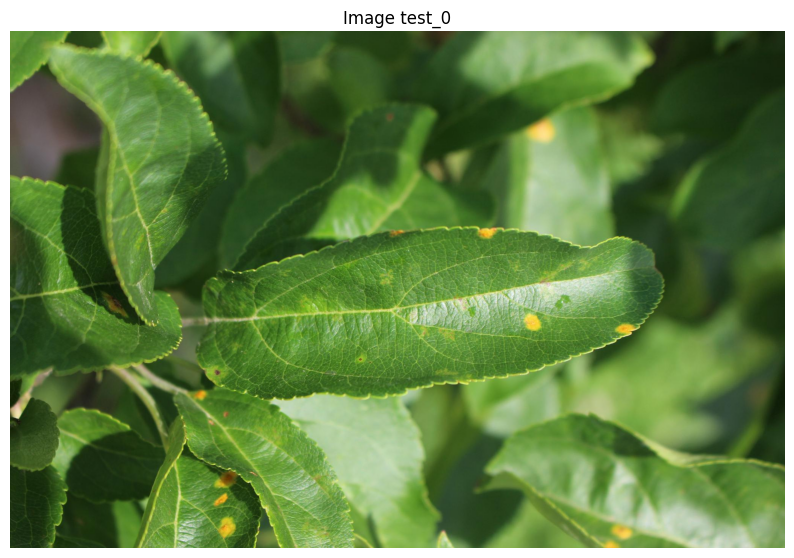

In [ ]:
image = cv.imread("images/Test_0.jpg")
if image is None:
    print("Impossible de charger l'image :", image_path)
else:
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    # Afficher l'image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title('Image test_0')
    plt.axis('off')
    plt.show()

  On peut observer que l'image test_0 contient des tâches jaunes et elle s'agit bien évidemment d'une feuille Rust !! super !

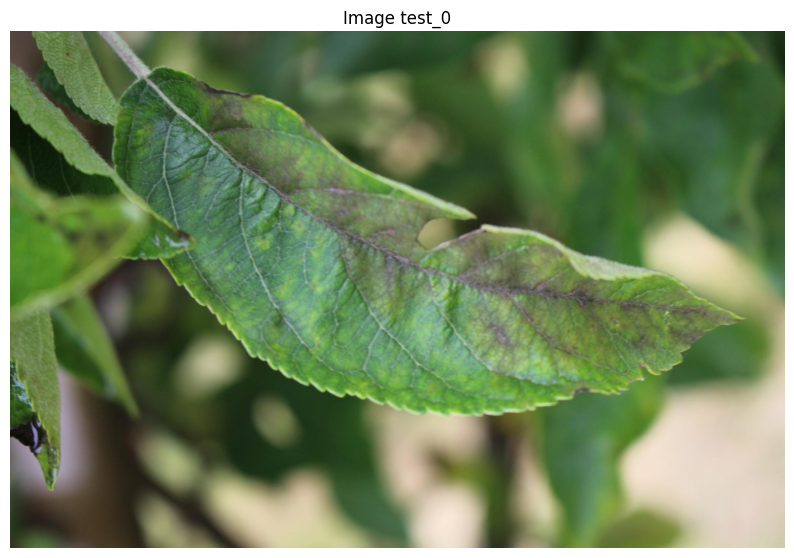

In [ ]:
image = cv.imread("images/Test_2.jpg")
if image is None:
    print("Impossible de charger l'image :", image_path)
else:
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    # Afficher l'image
    plt.figure(figsize=(6, 3))
    plt.imshow(image)
    plt.title('Image test_0')
    plt.axis('off')
    plt.show()

  On peut observer que l'image test_2 contient des tâches noires et la feuille enroulée donc elle s'agit bien évidemment d'une feuille Ssab !!

# 8. Interface Gradio


In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 111.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import tensorflow as tf
import numpy as np
import gradio as gr

# Charger le modèle
model_efficientnetb4 = tf.keras.models.load_model('best_model_efficientnetb4.keras')

# Définir les noms de classe
class_names = ['healthy', 'multiple_diseases', 'rust', 'scab']

# Fonction de prédiction
def predict_image(img):
    # Redimensionner l'image
    resized_img = tf.image.resize(img, (256, 256))

    # Normaliser l'image
    resized_img = resized_img / 255.0

    # Ajouter une dimension supplémentaire pour le lot
    img_4d = tf.expand_dims(resized_img, 0)

    # Faire la prédiction
    prediction = model_efficientnetb4.predict(img_4d)[0]

    # Afficher les prédictions brutes pour le débogage
    print(f"Raw prediction: {prediction}")

    # Déterminer la classe prédite
    predicted_class = class_names[np.argmax(prediction)]

    # Afficher le résultat
    if predicted_class == 'healthy':
        return "healthy : Cette feuille est saine."
    elif predicted_class == 'multiple_diseases':
        return "multiple_diseases : Cette feuille présente plusieurs maladies."
    elif predicted_class == 'rust':
        return "rust : Cette feuille est atteinte de rouille."
    elif predicted_class == 'scab':
        return "scab : Cette feuille est atteinte de tavelure."
    else:
        return "Impossible de déterminer l'état de cette feuille."

# Interface Gradio
image_input = gr.Image()
output_text = gr.Textbox()

gr.Interface(fn=predict_image, inputs=image_input, outputs=output_text).launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://93dfe5e88c6f0be463.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
